In [34]:
import pyrealsense2 as rs
import time
import numpy as np
import random
import math
import open3d as o3d
import pcl
import pptk
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

In [35]:
# Load original ply file and transfer to pcd file
ply = o3d.io.read_point_cloud("test0901_2.ply")
o3d.io.write_point_cloud("test0901.pcd", ply)

True

In [36]:
# Apply MLS smoothing methods to the point cloud
# Notice: It seems that the polynomial order doesn't affect the results. It's weird.

p = pcl.PointCloud_PointXYZRGB()
p.from_file("test0901.pcd") 

#Build a pcl.MovingLeastSquares object 
mls = p.make_moving_least_squares()

#Set a polynomial to approximate the surface and normal
mls.set_polynomial_fit(True)

#Set polynomial order 
mls.set_polynomial_order(2)

#Set the sphere radius
mls.set_search_radius(0.015)

#Apply smoothing and output file
mls.process().to_file("test0901_sm.pcd")

0

In [37]:
# Load the file after the smoothing
pcd_sm = o3d.io.read_point_cloud("test0901_sm.pcd")


# Voxel downsampling
# print("Downsample the point cloud with a voxel of 0.001")
downpcd = o3d.geometry.voxel_down_sample(pcd_sm, voxel_size=0.001)
# o3d.visualization.draw_geometries([downpcd])
    
# Vertex normal estimation

# print("Recompute the normal of the downsampled point cloud")
o3d.geometry.estimate_normals(
    downpcd,
    search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=0.05,
                                                          max_nn=30))
# o3d.visualization.draw_geometries([downpcd])
o3d.geometry.orient_normals_to_align_with_direction(downpcd)
# o3d.io.write_point_cloud("test0730_ne.pcd", downpcd)

# o3d.visualization.draw_geometries([downpcd])
    
# print("Print the normal vectors of the first 100 points")
# print(np.asarray(downpcd.normals)[:100, :])

True

In [38]:
# NOTICE: When we want to transfer point in point cloud [x, y, z] into robot base, 
# we need to reconstruct a point as [-z, -x, y]
# example: we have point [1, 2, 3] in point cloud, we need point [-3, -1, 2] to transfer into robot base

pcd = downpcd

rot1 = np.array([[0, 0, -1, 0],[-1, 0, 0, 0],[0, 1, 0, 0],[0, 0, 0, 1]])

qw = 0.747674083551
qx = 0.124738770189 
qy = 0.18702112
qz = -0.624857427476
tx = 0.674651134177 
ty = 0.767562821092
tz =  0.877107907672
r11 = 1-2*qy**2-2*qz**2
r12 = 2*qx*qy-2*qz*qw
r13 = 2*qx*qz+2*qy*qw
r21 = 2*qx*qy+2*qz*qw
r22 = 1-2*qx**2-2*qz**2
r23 = 2*qy*qz-2*qx*qw
r31 = 2*qx*qz-2*qy*qw
r32 = 2*qy*qz+2*qx*qw
r33 = 1-2*qx**2-2*qy**2
RotMat =  [[r11, r12, r13, tx], [r21, r22, r23, ty], [r31, r32, r33, tz], [0, 0, 0, 1]]
rot2 = np.asarray(RotMat)

pcd.transform(rot1)
pcd.transform(rot2)

geometry::PointCloud with 288772 points.

In [44]:
# Add limits to filter out the background

# Filter noise data

pcd, ind = o3d.geometry.statistical_outlier_removal(pcd, nb_neighbors=50, std_ratio=0.01)
pcd, ind = o3d.geometry.radius_outlier_removal(pcd, nb_points=50, radius=0.02)

pts = np.asarray(pcd.points).tolist()
norms = np.asarray(pcd.normals).tolist()
rgbs = np.asarray(pcd.colors).tolist()
rgb_lim = 255 / 255.0
len_offset = 0.476


x_min = 0
x_max = 1
y_min = -0.5
y_max = 1
z_min = 0.22
# x_min = 0.62518806 - 0.3
# x_max = 0.62518806 + 0.3
# y_min = -0.17314086 - 0.3
# y_max = -0.17314086 + 0.3
# z_min = 0.33917976 + 0.02

p_3d = []
p_norm = []
p_inv = []

for i in range(len(pts)):
    x_p = pts[i][0]
    y_p = pts[i][1]
    z_p = pts[i][2]
    r_p = rgbs[i][0]
    g_p = rgbs[i][1]
    b_p = rgbs[i][2]

    if (x_p > x_max or x_p < x_min or y_p > y_max or y_p < y_min or z_p < z_min 
                 or(r_p > rgb_lim and g_p > rgb_lim and b_p > rgb_lim)):
        p_inv.append(pts[i])
    else:
        p_3d.append(pts[i])
        p_norm.append(norms[i])

# print(p_3d[:10])
# print(p_norm[:10])


In [45]:
v = pptk.viewer(np.asarray(p_3d)) 
v.set(point_size=0.001)

In [95]:
# 3D viewer for processed points

rgb_3d = [[89 / 255.0, 159 / 255.0, 229 / 255.0, 0.3] for i in range(len(p_3d))]
l = len(p_3d)
scalars = np.arange(l)
v = pptk.viewer(np.asarray(p_3d), scalars)

v.attributes(rgb_3d)
# v.color_map(rgb_3d)
# v.color_map('cyan', scale=[0, 1])
v.set(point_size=0.002)
v.set(bg_color = [1, 1, 1, 0.3])
v.set(floor_color = [1, 1, 1, 0.3])
# v.set(show_grid = 0)

In [97]:
v.capture('cubic_1.png')

In [91]:
# 3D viewer for processed norms
vn = pptk.viewer(np.asarray(p_norm)) 
vn.set(point_size=0.01)

In [48]:
def calculate_wcss(norms, min_n, max_n):
    
    wcss = []
    for n in range(min_n, max_n + 1):
        kmeans = KMeans(n_clusters=n, init='k-means++', random_state=167)
        kmeans.fit(norms)
        wcss.append(kmeans.inertia_)
    
    K = range(min_n, max_n + 1)
    plt.plot(K, wcss, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Sum_of_squared_distances')
    plt.title('Elbow Method For Optimal k')
    plt.savefig('elbow_k.png')
    plt.show()
    
    return wcss

def optimal_num_of_clus(wcss, min_n, max_n):
    
    x1, y1 = min_n, wcss[0]
    x2, y2 = max_n, wcss[len(wcss) - 1]
    
    distances = []
    
    for i in range(len(wcss)):
        x0 = i + min_n
        y0 = wcss[i]
        
        segment = abs((y2 - y1) * x0 - (x2 - x1) * y0 + x2 * y1 - y2 * x1)
        norm = math.sqrt((y2 - y1)**2 + (x2 - x1)**2)
        distances.append(segment / norm)
    
    return distances.index(max(distances)) + min_n

def optimal_num_clus(norms, min_n, max_n):
    
    wcss = calculate_wcss(norms, min_n, max_n)
    
    return optimal_num_of_clus(wcss, min_n, max_n)

In [49]:
# print optimal_num_clus(p_norm, 1, 12)

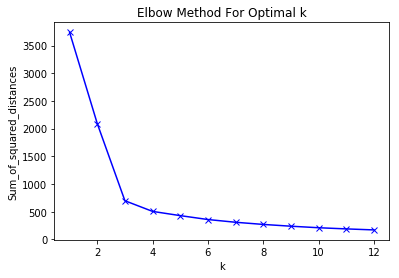

In [50]:
# K-means clustering
n_min = 1    # minimum num of cluster
n_max = 12   # maximum num of cluster
num_clus = optimal_num_clus(p_norm, n_min, n_max)
sample_len = len(p_norm)
kmeans = KMeans(n_clusters=num_clus, init='k-means++', random_state=167)
# f_pred is prefictor
f_pred = kmeans.fit(p_norm)

In [100]:
# label for each normal. 
# Example: labels[0] = 2 means p_norms[0] belongs to group 2
# labels[9] = 0 means p_norms[9] belongs to group 0
# Then group normals with same label
labels = f_pred.labels_
norm_groups = [[] for i in range(num_clus)]
for i in range(sample_len):
    l = labels[i]
    norm_groups[l].append(i)
    
# clus_centers are the centers of each group
clus_centers = f_pred.cluster_centers_

In [101]:
f_pred.cluster_centers_

array([[ 0.02126853,  0.29927202,  0.90713748],
       [-0.74181892,  0.5791658 ,  0.21596721],
       [ 0.29260587,  0.89205399,  0.14374081]])

0 : 34.063408
1 : 32.139400
2 : 33.797193


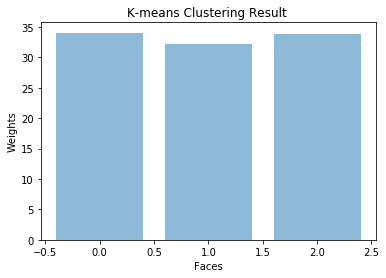

In [102]:
# Plot weights
counts = []
for i in range(num_clus):
    percent = labels.tolist().count(i) * 1.0 / sample_len * 100
    counts.append(percent)
    print "%d : %f" %(i, percent)


x_ax = np.arange(num_clus)
plt.bar(x_ax, counts, align='center', alpha=0.5)
plt.xlabel('Faces')
plt.ylabel('Weights')
plt.title('K-means Clustering Result ')
plt.savefig('kmeans_result.png')
plt.show()

In [103]:
ang = np.arccos(np.dot(clus_centers[0],clus_centers[1]))
np.degrees(ang)



69.30074536084976

In [104]:
def select_point_from_group(group, pts):
    """ Choose the points from index in groups
        Input: group with index
        Output: lists of points in the group
    """

    p_in_group = []

    for i in range(len(group)):
        p_in_group.append(pts[group[i]])
    
    return p_in_group

In [105]:
group_planes = []
for i in range(num_clus):
    group_t = select_point_from_group(norm_groups[i], p_3d)
    group_planes.append(group_t)

In [106]:
def fit_to_plane(pts):
    """Given points in a group, compute the plane which minimizes the distance from the points to the plane
       Output the norm vector norm and constant factor d
    """
    # Compute x_mean, y_mean, z_mean
    
    n = len(pts)
    
    x_total = 0
    y_total = 0
    z_total = 0

    for i in range(n):
        x_total += pts[i][0]
        y_total += pts[i][1]
        z_total += pts[i][2]

    x_mean = x_total * 1.0 / n
    y_mean = y_total * 1.0 / n
    z_mean = z_total * 1.0 / n

    # Compute the p[i] = [x[i]-x_mean,y[i]-y.mean,z[i]-z.mean]
    p = []
    for i in range(n):
        p1 = pts[i][0] - x_mean
        p2 = pts[i][1] - y_mean
        p3 = pts[i][2] - z_mean
        p.append([p1, p2, p3])
 
    # Compute the matrix A
    a1 = 0
    a2 = 0
    a3 = 0
    a4 = 0
    a5 = 0
    a6 = 0
    for i in range(n):
        a1 += p[i][0] * p[i][0]
        a2 += p[i][0] * p[i][1]
        a3 += p[i][0] * p[i][2]
        a4 += p[i][1] * p[i][1]
        a5 += p[i][1] * p[i][2]
        a6 += p[i][2] * p[i][2]

    A = np.array([[a1, a2, a3], [a2, a4, a5], [a3, a5, a6]])

    # Compute the smallest eigen value and accordingly eigen vector of A
    w, v = np.linalg.eigh(A)

    # The minimal eigenvalue is w[0]
    eig = w[0]

    # The norm is eigenvector v[:,0]
    norm = v[:,0].tolist()
    d = -norm[0] * x_mean - norm[1] * y_mean - norm[2] * z_mean

    return norm, d

In [107]:
def norm_align(norm, d, reference):
    
    """Let the norm of plane along with the estimated normal
    """
    
    if(np.dot(norm, reference) < 0):
        norm = [x * (-1.0) for x in norm]
        d = d * (-1.0)
    return norm, d

In [108]:
n_planes = []
d_planes = []
for i in range(num_clus):
    n_t, d_t = fit_to_plane(group_planes[i])
    n_t, d_t = norm_align(n_t, d_t, clus_centers[i])
    n_planes.append(n_t)
    d_planes.append(d_t)

In [109]:
ang = np.arccos(np.dot(n_planes[1],n_planes[0]))
np.degrees(ang)

77.21855101102409

In [110]:
def proj_to_plane(norm, d, pts):
    """ Project points on to a certain plane
        Input: plane's norm (normalized), and a bunch of points
        Output: All the projection of points on the plane

    """
    a = norm[0]
    b = norm[1]
    c = norm[2]

    p = []

    for i in range(len(pts)):
        x_p = pts[i][0]
        y_p = pts[i][1]
        z_p = pts[i][2]

        if a != 0:
            x_0 = (b * b + c * c) * x_p - a * b * y_p - a * c * z_p - a * d
            y_0 = (b * 1.0 / a) * (x_0 - x_p) + y_p
            z_0 = (c * 1.0 / a) * (x_0 - x_p) + z_p

        elif b != 0:
            x_0 = x_p 
            y_0 = c * c * y_p - b * (d + c)
            z_0 = (c * 1.0 / b) *(y_0 - y_p) + z_p

        else:
            x_0 = x_p
            y_0 = y_p
            z_0 = - d * 1.0 / c

        p.append([x_0, y_0, z_0])
        
    return p

In [111]:
pts_planes = []
for i in range(num_clus):
    pts_t = proj_to_plane(n_planes[i], d_planes[i], group_planes[i])
    pts_planes.append(pts_t)

In [112]:
rgb_3d = [[89 / 255.0, 159 / 255.0, 229 / 255.0, 0.3] for i in range(len(pts_planes[0]))]
l = len(pts_planes[0])
scalars = np.arange(l)
v1 = pptk.viewer(np.asarray(pts_planes[0]), scalars)
v1.set(point_size=0.001)
v1.attributes(rgb_3d)
v1.set(bg_color = [1, 1, 1, 0.3])
v1.set(floor_color = [1, 1, 1, 0.3])

In [ ]:
v1.capture('v1_screenshot.png')

In [64]:
rgb_3d = [[89 / 255.0, 159 / 255.0, 229 / 255.0, 0.3] for i in range(len(pts_planes[1]))]
l = len(pts_planes[1])
scalars = np.arange(l)
v2 = pptk.viewer(np.asarray(pts_planes[1]), scalars)
v2.set(point_size=0.001)
v2.attributes(rgb_3d)
v2.set(bg_color = [1, 1, 1, 0.3])
v2.set(floor_color = [1, 1, 1, 0.3])

In [ ]:
v2.capture('v2_screenshot.png')

In [68]:
rgb_3d = [[89 / 255.0, 159 / 255.0, 229 / 255.0, 0.3] for i in range(len(pts_planes[2]))]
l = len(pts_planes[2])
scalars = np.arange(l)
v3 = pptk.viewer(np.asarray(pts_planes[2]), scalars)
v3.set(point_size=0.001)
v3.attributes(rgb_3d)
v3.set(bg_color = [1, 1, 1, 0.3])
v3.set(floor_color = [1, 1, 1, 0.3])

In [ ]:
v3.capture('v3_screenshot.png')

In [82]:
l = len(pts_planes[0]) + len(pts_planes[1]) + len(pts_planes[2])
rgb_3d = [[89 / 255.0, 159 / 255.0, 229 / 255.0, 0.3] for i in range(l)]
scalars = np.arange(l)
v4 = pptk.viewer(np.asarray(pts_planes[0] + pts_planes[1] + pts_planes[2]), scalars)
v4.set(point_size=0.001)
v4.attributes(rgb_3d)
v4.set(bg_color = [1, 1, 1, 0.3])
v4.set(floor_color = [1, 1, 1, 0.3])

In [83]:
v4.capture('v4_screenshot.png')

In [113]:
def build_coord(norm, d, pts):
    """Given the function of a plane (in global accordinate system) and a lot of points on the plane,
       construct an accordinate system
       Set the origin in the center of points.
       Output the coordinates
    """
    # Compute the origin as the mean point of the points, and this point has to be on the plane
    
    n = len(pts)
    x_total = 0
    y_total = 0
    z_total = 0
    
    for i in range(n):
        x_total += pts[i][0]
        y_total += pts[i][1]
        z_total += pts[i][2]

    x_o = x_total * 1.0 / n
    y_o = y_total * 1.0 / n
    z_o = z_total * 1.0 / n
    p_o = [x_o, y_o, z_o]
    
    # Choose p be the projection of a vector in the z-axis to the plane
    # If the plane is not perpendicular to the z-axis
    if ((norm[2] != 1) and (norm[2] != -1)): 
        # Choose a point
        o_z = [x_o, y_o, z_o + 1]
    
        [[x_p, y_p, z_p]] = proj_to_plane(norm, d, [o_z])
     
        dist = np.linalg.norm([x_p - x_o, y_p - y_o, z_p - z_o])

        x_c = (x_p - x_o) * 1.0 / dist 
        y_c = (y_p - y_o) * 1.0 / dist
        z_c = (z_p - z_o) * 1.0 / dist
        # Thus we have unit vector in x direction
        e_y = [x_c, y_c, z_c]
        #Compute the unit vector in y direction
        e_x = np.cross(e_y, norm).tolist()
    else:
        e_x = [1, 0, 0]
        e_y = [0, 1, 0]
        
    return [e_x, e_y, norm] , p_o

In [114]:
coordinate_planes = []
o_planes = []
for i in range(num_clus):
    coordinate_t, o_t = build_coord(n_planes[i], d_planes[i], pts_planes[i])
    coordinate_planes.append(coordinate_t)
    o_planes.append(o_t)

In [115]:
n_planes

[[0.011536586742529992, 0.16481819263781985, 0.9862564932825209],
 [-0.8358920135690839, 0.5292160358719502, 0.1456534552539028],
 [0.33622755966381096, 0.9366906674199754, 0.09778354509240833]]

In [116]:
def compute_T_matrix(coordinates, p, reference=[[1,0,0],[0,1,0],[0,0,1]], origin=[0,0,0]):
    """Compute the tranform matrix from origin to the coordinates and its inverse
    """
    e_b_x = coordinates[0]
    e_b_y = coordinates[1]
    e_b_z = coordinates[2]
    
    e_a_x = reference[0] 
    e_a_y = reference[1]
    e_a_z = reference[2]
    
    # Compute the rotation matrix
    x_b_a = [np.dot(e_b_x, e_a_x), np.dot(e_b_x, e_a_y), np.dot(e_b_x, e_a_z)]
    y_b_a = [np.dot(e_b_y, e_a_x), np.dot(e_b_y, e_a_y), np.dot(e_b_y, e_a_z)]
    z_b_a = [np.dot(e_b_z, e_a_x), np.dot(e_b_z, e_a_y), np.dot(e_b_z, e_a_z)]
    
    R_b_a = [[x_b_a[0], y_b_a[0], z_b_a[0]],[x_b_a[1], y_b_a[1], z_b_a[1]],x_b_a[2], y_b_a[2], z_b_a[2]]
    
    # Compute the displacement 
    displacement = [p[0]-origin[0], p[1]-origin[1], p[2]-origin[2]]
    
    # Make it into a transform matrix
    T_b_a = [[x_b_a[0], y_b_a[0], z_b_a[0], displacement[0]],
         [x_b_a[1], y_b_a[1], z_b_a[1], displacement[1]],
         [x_b_a[2], y_b_a[2], z_b_a[2], displacement[2]],
         [0, 0, 0, 1]]
    
    T_a_b = np.linalg.inv(T_b_a).tolist()
    
    return T_b_a, T_a_b

In [117]:
T_matrix = []
T_inv = []
for i in range(num_clus):
    T_t, T_t_inv = compute_T_matrix(coordinate_planes[i], o_planes[i])
    T_matrix.append(T_t)
    T_inv.append(T_t_inv)

In [118]:
T_matrix

[[[-0.9975592566689601,
   -0.06886535123271019,
   0.011536586742529992,
   0.7541343416889592],
  [0.06982499147205444,
   -0.9838492943238446,
   0.16481819263781985,
   -0.26568875400380787],
  [1.734723475976807e-18,
   0.16522145580422826,
   0.9862564932825209,
   0.33197388488209434],
  [0, 0, 0, 1]],
 [[-0.534920604905087,
   0.12306294364835349,
   -0.8358920135690839,
   0.6866364301208606],
  [-0.8449023295316302,
   -0.07791303439093368,
   0.5292160358719502,
   -0.24836172910736692],
  [-1.3877787807814457e-17,
   0.9893356715355004,
   0.1456534552539028,
   0.2776420109846834],
  [0, 0, 0, 1]],
 [[-0.9412011800805486,
   -0.03303584019668237,
   0.33622755966381096,
   0.7823104092851937],
  [0.33784661995494686,
   -0.0920339880334345,
   0.9366906674199754,
   -0.20416239858076268],
  [3.469446951953614e-18,
   0.9952077061142367,
   0.09778354509240833,
   0.27121011865281197],
  [0, 0, 0, 1]]]

In [119]:
def trans_to_coordinates(T, pts):
    """Transfer all the points to a new fram using transformation matrix.
    """
    p = []
    for i in range(len(pts)):
        
        p_b = [pts[i][0], pts[i][1], pts[i][2], 1]
        p_a = np.matmul(T, p_b).tolist()
        p.append(p_a[0:3])

    return p

In [120]:
points_in_planes = []
for i in range(num_clus):
    points_in_t = trans_to_coordinates(T_inv[i], pts_planes[i])
    points_in_planes.append(points_in_t)

In [180]:
l = len(points_in_planes[0]) 
rgb_3d = [[89 / 255.0, 159 / 255.0, 229 / 255.0, 0.3] for i in range(l)]
scalars = np.arange(l)
v5 = pptk.viewer(np.asarray(points_in_planes[0]), scalars)
v5.set(point_size=0.001)
v5.attributes(rgb_3d)
v5.set(bg_color = [1, 1, 1, 0.3])
v5.set(floor_color = [1, 1, 1, 0.3])

In [181]:
v5.capture('v5_screenshot.png')

In [132]:
l = len(points_in_planes[1]) 
rgb_3d = [[89 / 255.0, 159 / 255.0, 229 / 255.0, 0.3] for i in range(l)]
scalars = np.arange(l)
v6 = pptk.viewer(np.asarray(points_in_planes[1]), scalars)
v6.set(point_size=0.001)
v6.attributes(rgb_3d)
v6.set(bg_color = [1, 1, 1, 0.3])
v6.set(floor_color = [1, 1, 1, 0.3])

In [133]:
v6.capture('v6_screenshot.png')

In [134]:
l = len(points_in_planes[2]) 
rgb_3d = [[89 / 255.0, 159 / 255.0, 229 / 255.0, 0.3] for i in range(l)]
scalars = np.arange(l)
v7 = pptk.viewer(np.asarray(points_in_planes[2]), scalars)
v7.set(point_size=0.001)
v7.attributes(rgb_3d)
v7.set(bg_color = [1, 1, 1, 0.3])
v7.set(floor_color = [1, 1, 1, 0.3])

In [135]:
v7.capture('v7_screenshot.png')

In [136]:
def trans_to_end(pts,dx=0.05, dz=0.03):
    """Transfer to the end-effector coordinate
    """
    p = []
    for i in range(len(pts)):
        p.append([pts[i][0]+dx, pts[i][1],pts[i][2]+dz])
    return p

In [137]:
def segement_divide(pts,step=0.10, offset_x=0.01, offset_y=0.0):
    """Divide the points on the plane into a sequence of rectangles.
    
    """

    # Select the x and y of the points
    n = len(pts)
    
    z = 0.0
    
    points_plane = []    
    points_x = []
    paint_point = []

    for i in range(n):
        points_plane.append([pts[i][0], pts[i][1]])
        
    # Sorted the list according to x 
    points_plane.sort(key=lambda x:x[0])

    # Segment the points according to x 
    counter = 0   # Count the interval
    x_min = points_plane[0][0]
    x_max = points_plane[n-1][0]

    # The whole interval that needs to be divided
    upper = x_max + offset_x
    lower = x_min - offset_x
    lower_bound = lower
    
    # Set each segement's lower and upperbound
    while (lower_bound + step <= upper):       
        # The break condition will be lower_bound > upper - step
        upper_bound = lower_bound + step

        # Find the index between lower bound and upper bound
        # First, find the index which x >= lower bound
        index = 0
        
        while (points_plane[index][0] < lower_bound): 
            index = index + 1  # The index of the first point in the interval
            
        # If there is at least one point in the [lower_bound, upper_bound]
        if (points_plane[index][0] <= upper_bound): 

            x_start = points_plane[index][0]
            y_max = points_plane[index][1]
            y_min = points_plane[index][1]
        
            while (points_plane[index][0] <= upper_bound): 
                # The break condition will be x[index] > upper bound or index = n - 1
                # Compute the y max and y min in this interval
                
                if points_plane[index][1] > y_max:   
                    y_max = points_plane[index][1]

                if points_plane[index][1] < y_min:
                    y_min = points_plane[index][1]
                
                if index < n - 1:
                    index = index + 1
                else:
                    break
            # The index of the last point in the interval, when index < n-1
            
            x_end = points_plane[index][0]

            paint_point.append([lower_bound,y_max+offset_y,z]) 
            paint_point.append([lower_bound,y_min-offset_y,z])
            points_x.append([x_start, x_end])
            
        counter = counter + 1

        # Update interval
        lower_bound = upper_bound - offset_x
    
    # Deal with the last interval
    lower_bound_last = upper - step
    index_last = 0
    counter = counter + 1
    while ((index_last < n) and (points_plane[index_last][0] < lower_bound_last)): 
        # The first point in the last interval
        index_last = index_last + 1
        
    if (index_last < n): 
        # There is at least one point in the last interval
        x_start_last = points_plane[index_last][0]
        y_max_last = points_plane[index_last][1]
        y_min_last = points_plane[index_last][1]

        while ((index_last)<n) and (points_plane[index_last][0] <= upper):

            if points_plane[index_last][1] > y_max_last:   
                y_max_last = points_plane[index_last][1]
            
            if points_plane[index_last][1] < y_min_last:
                y_min_last = points_plane[index_last][1]

            index_last = index_last + 1
            
        index_last = index_last - 1 # The index of the last point in the interval
        
        paint_point.append([lower_bound_last, y_max_last+offset_y, z])
        paint_point.append([lower_bound_last, y_min_last-offset_y, z])
#     paint_point.append([upper, y_max_last+offset_y, z])
#     paint_point.append([upper, y_min_last-offset_y, z])
#     return trans_to_end(paint_point)
        return paint_point
#     return paint_point

In [138]:
# Note: sometime segement_divide will have error
paint_points_ps = []
for i in range(num_clus):
    paint_t = segement_divide(points_in_planes[i])
    paint_points_ps.append(paint_t)

In [139]:
paint_points_ps

[[[-0.09054640168757465, 0.0726191378108072, 0.0],
  [-0.09054640168757465, -0.05750688090707696, 0.0],
  [-0.0006725792158778637, 0.07140555455831626, 0.0],
  [-0.0006725792158778637, -0.07400232048409117, 0.0]],
 [[-0.08545356432972238, 0.052513282794477645, 0.0],
  [-0.08545356432972238, -0.05829592253851135, 0.0],
  [-0.016209105860906722, 0.06461961504370883, 0.0],
  [-0.016209105860906722, -0.0582488800320512, 0.0]],
 [[-0.08444797289096127, 0.05275399876132045, 0.0],
  [-0.08444797289096127, -0.051231127479928085, 0.0],
  [-0.02669405102723381, 0.04967067524106006, 0.0],
  [-0.02669405102723381, -0.051231127479928085, 0.0]]]

In [140]:
p8 = points_in_planes[0] + paint_points_ps[0]
l1 = len(points_in_planes[0]) 
l2 = len(paint_points_ps[0])
rgb_3d1 = [[89 / 255.0, 159 / 255.0, 229 / 255.0, 0.3] for i in range(l1)]
rgb_3d2 = [[242 / 255.0, 17 / 255.0, 17 / 255.0, 0.8] for i in range(l2)]
rgb_3d = rgb_3d1 + rgb_3d2
scalars = np.arange(l1 + l2)
v8 = pptk.viewer(np.asarray(p8), scalars)
v8.set(point_size=0.001)
v8.attributes(rgb_3d)
v8.set(bg_color = [1, 1, 1, 0.3])
v8.set(floor_color = [1, 1, 1, 0.3])

In [141]:
v8.capture('v8_screenshot.png')

In [142]:
p9 = points_in_planes[1] + paint_points_ps[1]
l1 = len(points_in_planes[1]) 
l2 = len(paint_points_ps[1])
rgb_3d1 = [[89 / 255.0, 159 / 255.0, 229 / 255.0, 0.3] for i in range(l1)]
rgb_3d2 = [[242 / 255.0, 17 / 255.0, 17 / 255.0, 0.8] for i in range(l2)]
rgb_3d = rgb_3d1 + rgb_3d2
scalars = np.arange(l1 + l2)
v9 = pptk.viewer(np.asarray(p9), scalars)
v9.set(point_size=0.001)
v9.attributes(rgb_3d)
v9.set(bg_color = [1, 1, 1, 0.3])
v9.set(floor_color = [1, 1, 1, 0.3])

In [143]:
v9.capture('v9_screenshot.png')

In [144]:
p10 = points_in_planes[2] + paint_points_ps[2]
l1 = len(points_in_planes[2]) 
l2 = len(paint_points_ps[2])
rgb_3d1 = [[89 / 255.0, 159 / 255.0, 229 / 255.0, 0.3] for i in range(l1)]
rgb_3d2 = [[242 / 255.0, 17 / 255.0, 17 / 255.0, 0.8] for i in range(l2)]
rgb_3d = rgb_3d1 + rgb_3d2
scalars = np.arange(l1 + l2)
v10 = pptk.viewer(np.asarray(p10), scalars)
v10.set(point_size=0.001)
v10.attributes(rgb_3d)
v10.set(bg_color = [1, 1, 1, 0.3])
v10.set(floor_color = [1, 1, 1, 0.3])

In [145]:
v10.capture('v10_screenshot.png')

In [146]:
paint_strokes = []
for i in range(num_clus):
    stroke = trans_to_coordinates(T_matrix[i], paint_points_ps[i])
    paint_strokes.append(stroke)

In [147]:
len(paint_strokes[0])/2

2

In [148]:
paint_strokes[0]

[[0.8394588004189074, -0.3434574432190367, 0.3439721245504438],
 [0.8484199744024287, -0.21543305153027495, 0.32247251429986673],
 [0.7498879107169765, -0.3359880213048231, 0.3437716145587276],
 [0.7599014751037739, -0.19292858605522073, 0.31974711375882175]]

In [149]:
def divide_strokes(stroke):
    strokes = []
    for i in range(len(stroke)/2):
        stroke_1 = stroke[i * 2]
        stroke_2 = stroke[i*2+1]
        strokes.append([stroke_1, stroke_2])

    return strokes

In [150]:
divide_strokes(paint_strokes[0])

[[[0.8394588004189074, -0.3434574432190367, 0.3439721245504438],
  [0.8484199744024287, -0.21543305153027495, 0.32247251429986673]],
 [[0.7498879107169765, -0.3359880213048231, 0.3437716145587276],
  [0.7599014751037739, -0.19292858605522073, 0.31974711375882175]]]

In [151]:
v11 = pptk.viewer(np.asarray(paint_strokes[0]))
v11.set(point_size=0.001)

In [152]:
v12 = pptk.viewer(np.asarray(paint_strokes[1]))
v12.set(point_size=0.001)

In [153]:
v13 = pptk.viewer(np.asarray(paint_strokes[2]))
v13.set(point_size=0.001)

In [155]:
all_pts_planes = pts_planes[0] + pts_planes[1] + pts_planes[2]
all_paint_strokes = paint_strokes[0] + paint_strokes[1] + paint_strokes[2]
l1 = len(all_pts_planes) 
l2 = len(paint_strokes[0])
l3 = len(paint_strokes[1])
l4 = len(paint_strokes[2])
rgb_3d1 = [[89 / 255.0, 159 / 255.0, 229 / 255.0, 0.3] for i in range(l1)]
rgb_3d2 = [[242 / 255.0, 17 / 255.0, 17 / 255.0, 0.8] for i in range(l2)]
rgb_3d3 = [[240 / 255.0, 166 / 255.0, 16 / 255.0, 0.8] for i in range(l3)]
rgb_3d4 = [[166 / 255.0, 16 / 255.0, 171 / 255.0, 0.8] for i in range(l4)]
rgb_3d = rgb_3d1 + rgb_3d2 + rgb_3d3 + rgb_3d4
scalars = np.arange(l1 + l2 + l3 + l4)

v14 = pptk.viewer(np.asarray(all_pts_planes + all_paint_strokes), scalars)
v14.set(point_size=0.001)
v14.attributes(rgb_3d)
v14.set(bg_color = [1, 1, 1, 0.3])
v14.set(floor_color = [1, 1, 1, 0.3])

In [156]:
v14.capture('paintingAll.png')

In [157]:
from scipy.spatial.transform import Rotation as R

def coor_to_quater(coordinate):
    """Transfer dcm to quaternion
    """
    rotation = np.transpose(coordinate)
    
    r = R.from_dcm(rotation)
    
    q = r.as_quat()
#     m = r.as_dcm()
    
    return q.tolist()

In [158]:
def norm_to_base(coordinate):
    [f_x, f_y, f_z] = coordinate
    e_x = [y * (-1.0) for y in f_y]
    e_y = [x * (-1.0) for x in f_x]
    e_z = [z * (-1.0) for z in f_z] 
    return [e_x, e_y, e_z]

In [159]:
def move_up_by_normal(limb, Q, pos, N, d):
    '''
    This function move the roller to the position above the staring point of stroke
    pos is the starting point of stroke
    Q is the quaternion
    N is the normal of cooresponding surface
    d is the distance to move up
    '''
    x_d = d * N[0]
    y_d = d * N[1]
    z_d = d * N[2]
    x_n = pos[0] + x_d
    y_n = pos[1] + y_d
    z_n = pos[2] + z_d
    new_pose = [x_n, y_n, z_n] + Q # list contatenation
    move_to_position(limb, new_pose)
    
def move_up_current(limb, N, d):
    '''
    This function move up the roller
    N is the normal of cooresponding surface
    d is the distance to move up
    '''
    x_d = d * N[0]
    y_d = d * N[1]
    z_d = d * N[2]
    move_to_RelativP(limb, [x_d, y_d, z_d, 0, 0, 0, 0])

In [160]:
norm_to_base(coordinate_planes[0])

[[0.06886535123271019, 0.9838492943238446, -0.16522145580422826],
 [0.9975592566689601, -0.06982499147205444, -1.734723475976807e-18],
 [-0.011536586742529992, -0.16481819263781985, -0.9862564932825209]]

In [161]:
coordinate_planes

[[[-0.9975592566689601, 0.06982499147205444, 1.734723475976807e-18],
  [-0.06886535123271019, -0.9838492943238446, 0.16522145580422826],
  [0.011536586742529992, 0.16481819263781985, 0.9862564932825209]],
 [[-0.534920604905087, -0.8449023295316302, -1.3877787807814457e-17],
  [0.12306294364835349, -0.07791303439093368, 0.9893356715355004],
  [-0.8358920135690839, 0.5292160358719502, 0.1456534552539028]],
 [[-0.9412011800805486, 0.33784661995494686, 3.469446951953614e-18],
  [-0.03303584019668237, -0.0920339880334345, 0.9952077061142367],
  [0.33622755966381096, 0.9366906674199754, 0.09778354509240833]]]

In [162]:
quaternion_end = []
for i in range(num_clus):
    quaternion_end.append(coor_to_quater(norm_to_base(coordinate_planes[i])))


In [163]:
quaternion_end

[[0.7288598692456743,
  0.6796260277861924,
  -0.060628266833270744,
  0.056532880870638645],
 [0.21076538026554478,
  0.7269144943584985,
  -0.18200766389277426,
  0.6277312184823561],
 [0.6059426551341384,
  0.4262924714737463,
  -0.549323956028193,
  0.38646011280251386]]

In [164]:
quaternion_plane = []
for i in range(num_clus):
    quaternion_plane.append(coor_to_quater(coordinate_planes[i]))

In [165]:
quaternion_plane

[[0.0028958751857510487,
  0.08284544203303312,
  0.9959499289968504,
  0.03481358315986265],
 [-0.31517414798486554,
  0.5725718547178709,
  0.6630397979288128,
  -0.36497253867855656],
 [0.11516212795498042,
  0.6616992607965317,
  0.7299004578033897,
  0.12703186310767198]]

In [166]:
v = pptk.viewer(np.asarray(pts_planes[0] + pts_planes[1] + pts_planes[2]))
v.set(point_size=0.001)

In [167]:
v8 = pptk.viewer(np.asarray(paint_points_ps[0]+points_in_planes[0]))
v8.set(point_size=0.001)

In [168]:
v10 = pptk.viewer(np.asarray(paint_points_ps[2]+points_in_planes[2]))
v10.set(point_size=0.001)

In [169]:
v14 = pptk.viewer(np.asarray(paint_strokes[0] + paint_strokes[1]+ paint_strokes[2]+ pts_planes[0] + pts_planes[1] + pts_planes[2]))
v14.set(point_size=0.001)

In [170]:
def obstacles_on_face(face_id,T_matrix,quaternion,paint_points,width=0.10,offset=0.01):
    """Given paint_points on a face, output the obstacles' names, poses in a list
    """
    obstacles = []
    for i in range(len(paint_points)/2):
        stroke_1 = paint_points[i*2]
        stroke_2 = paint_points[i*2+1]
        x_o = (stroke_1[0] + stroke_2[0]) / 2.0
        y_o = (stroke_1[1] + stroke_2[1]) / 2.0 + width / 2.0
        z_o = offset / 2.0
        center = trans_to_coordinates(T_matrix, [[x_o, y_o, z_o]])
        obstacle_name = "face %d obstacle %d" % (face_id, i)
        obstacles.append([obstacle_name, center[0][0], center[0][1], center[0][2], quaternion[0], quaternion[1], quaternion[2],quaternion[3],[width, stroke_1[1] - stroke_2[1],offset]])
    # print obstacles
    return obstacles

In [171]:
num_planes = 3

In [172]:
obstacles = []
for i in range(num_planes):
    obstacles.append(obstacles_on_face(i, T_matrix[i], quaternion_plane[i], paint_points_ps[i]))

In [173]:
paint_points_ps

[[[-0.09054640168757465, 0.0726191378108072, 0.0],
  [-0.09054640168757465, -0.05750688090707696, 0.0],
  [-0.0006725792158778637, 0.07140555455831626, 0.0],
  [-0.0006725792158778637, -0.07400232048409117, 0.0]],
 [[-0.08545356432972238, 0.052513282794477645, 0.0],
  [-0.08545356432972238, -0.05829592253851135, 0.0],
  [-0.016209105860906722, 0.06461961504370883, 0.0],
  [-0.016209105860906722, -0.0582488800320512, 0.0]],
 [[-0.08444797289096127, 0.05275399876132045, 0.0],
  [-0.08444797289096127, -0.051231127479928085, 0.0],
  [-0.02669405102723381, 0.04967067524106006, 0.0],
  [-0.02669405102723381, -0.051231127479928085, 0.0]]]

In [174]:
T_matrix

[[[-0.9975592566689601,
   -0.06886535123271019,
   0.011536586742529992,
   0.7541343416889592],
  [0.06982499147205444,
   -0.9838492943238446,
   0.16481819263781985,
   -0.26568875400380787],
  [1.734723475976807e-18,
   0.16522145580422826,
   0.9862564932825209,
   0.33197388488209434],
  [0, 0, 0, 1]],
 [[-0.534920604905087,
   0.12306294364835349,
   -0.8358920135690839,
   0.6866364301208606],
  [-0.8449023295316302,
   -0.07791303439093368,
   0.5292160358719502,
   -0.24836172910736692],
  [-1.3877787807814457e-17,
   0.9893356715355004,
   0.1456534552539028,
   0.2776420109846834],
  [0, 0, 0, 1]],
 [[-0.9412011800805486,
   -0.03303584019668237,
   0.33622755966381096,
   0.7823104092851937],
  [0.33784661995494686,
   -0.0920339880334345,
   0.9366906674199754,
   -0.20416239858076268],
  [3.469446951953614e-18,
   0.9952077061142367,
   0.09778354509240833,
   0.27121011865281197],
  [0, 0, 0, 1]]]

In [175]:
coordinate_planes

[[[-0.9975592566689601, 0.06982499147205444, 1.734723475976807e-18],
  [-0.06886535123271019, -0.9838492943238446, 0.16522145580422826],
  [0.011536586742529992, 0.16481819263781985, 0.9862564932825209]],
 [[-0.534920604905087, -0.8449023295316302, -1.3877787807814457e-17],
  [0.12306294364835349, -0.07791303439093368, 0.9893356715355004],
  [-0.8358920135690839, 0.5292160358719502, 0.1456534552539028]],
 [[-0.9412011800805486, 0.33784661995494686, 3.469446951953614e-18],
  [-0.03303584019668237, -0.0920339880334345, 0.9952077061142367],
  [0.33622755966381096, 0.9366906674199754, 0.09778354509240833]]]

In [176]:
n_planes

[[0.011536586742529992, 0.16481819263781985, 0.9862564932825209],
 [-0.8358920135690839, 0.5292160358719502, 0.1456534552539028],
 [0.33622755966381096, 0.9366906674199754, 0.09778354509240833]]

In [177]:
paint_points_end = []
num_planes = 3
for i in range(num_planes):
    paint_points_end.append(trans_to_end(paint_points_ps[i]))
    
paint_points_world = []
for i in range(num_planes):   
    stroke = trans_to_coordinates(T_matrix[i], paint_points_end[i])
    paint_points_world.append(stroke)
      

In [178]:
paint_points_end

[[[-0.040546401687574646, 0.0726191378108072, 0.03],
  [-0.040546401687574646, -0.05750688090707696, 0.03],
  [0.04932742078412214, 0.07140555455831626, 0.03],
  [0.04932742078412214, -0.07400232048409117, 0.03]],
 [[-0.03545356432972238, 0.052513282794477645, 0.03],
  [-0.03545356432972238, -0.05829592253851135, 0.03],
  [0.03379089413909328, 0.06461961504370883, 0.03],
  [0.03379089413909328, -0.0582488800320512, 0.03]],
 [[-0.03444797289096127, 0.05275399876132045, 0.03],
  [-0.03444797289096127, -0.051231127479928085, 0.03],
  [0.023305948972766194, 0.04967067524106006, 0.03],
  [0.023305948972766194, -0.051231127479928085, 0.03]]]

In [179]:
paint_points_world

[[[0.7899269351877354, -0.3350216478662994, 0.3735598193489194],
  [0.7988881091712566, -0.20699725617753761, 0.35206020909834235],
  [0.7003560454858043, -0.3275522259520857, 0.37335930935720324],
  [0.7103696098726018, -0.18449279070248342, 0.34933480855729737]],
 [[0.6869869509524115, -0.20662191814717343, 0.33396487854030865],
  [0.673350443960799, -0.19798843672123223, 0.22433737896988082],
  [0.6514365042253228, -0.2660699634955144, 0.3459421048859337],
  [0.6363159455396565, -0.2564969062131145, 0.2243839197996003]],
 [[0.8230769361386485, -0.19255497065438953, 0.3266448111011912],
  [0.8265121721519862, -0.18298480479024726, 0.22315801214463896],
  [0.7688207369093184, -0.1727592328036202, 0.3235762637733848],
  [0.7721541127395661, -0.16347283749944486, 0.22315801214463896]]]